In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import warnings
warnings.filterwarnings('ignore')
sns.set(style="darkgrid")
%matplotlib inline

# Dataset Online Retail

Este archivo reune todas las transacciones de un e-commerce británico dedicado a artículos de regalo y decoración durante un año.

In [92]:
df = pd.read_excel("Online Retail.xlsx")

Vamos a comenzar a dar una primera mirada sobre que contiene el dataset

In [93]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


A continuación vamos a ver los tipos de datos de las features y sus cantidades

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Como podemos observar la mayoría tiene el mismo valor de 541909 menos Description y CustomerID. 
Prosigamos...

Ahora veamos la cantidad de filas y columnas del dataset

In [95]:
print("Número de filas: ", df.shape[0])
print("Número de columnas: ", df.shape[1])

Número de filas:  541909
Número de columnas:  8


In [96]:
print("Número de IDs únicos:", len(df['CustomerID'].unique().tolist()))

Número de IDs únicos: 4373


Para la segmentación de clientes, se eliminarán los identificadores faltantes.

A partir de las estadísticas descriptivas de las variables cuantitativas (cantidad y precio unitario), observamos que contienen valores negativos, que no son valores posibles para el precio y la cantidad.

In [97]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


Analicemos con más detalle el motivo de los valores negativos en estas variables. En la descripción del conjunto de datos se indica que se presentan algunas transacciones canceladas. Las transacciones canceladas se indican mediante un número de factura que empieza por la letra "c". Es probable que las transacciones con valores negativos de cantidad se cancelen.

Filtrando transacciones con un número de factura que empieza por la letra "C":

In [98]:
cancelados = df[df['InvoiceNo'].astype(str).str.contains('C')]
cancelados.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


Entre las transacciones canceladas no hay ninguna transacción con cantidad positiva

In [99]:
cancelados[cancelados['Quantity']>0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


Sin embargo, algunas transacciones con cantidad negativa no pertenecen a canceladas:

In [100]:
print("Numero de transacciones canceladas:", len(cancelados))
print("Numero total de transacciones con cantidad negativa:", df[df['Quantity'] <= 0 ]['Quantity'].count())

Numero de transacciones canceladas: 9288
Numero total de transacciones con cantidad negativa: 10624


También existen transacciones con precio cero. Estas transacciones no aportan información útil para el análisis; además, generalmente carecen de descripción. Estas transacciones se van a eliminar.

In [101]:
df[df['UnitPrice'] == 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom


También hay dos transacciones con precio negativo. Según la descripción, estas transacciones probablemente se realizaron como corrección, por lo que también deberían eliminarse.

In [102]:
df[df['UnitPrice'] < 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


Como se mencionó anteriormente, hay algunas transacciones de cantidad negativa que no se cancelan, sin embargo, todas estas transacciones tienen precio 0.

In [103]:
d = df[~df['InvoiceNo'].astype(str).str.contains('C')]  
print("Número de transacciones con valor de cantidad negativo entre las transacciones no canceladas:" ,len(d[d['Quantity']<=0]))
print("Número de transacciones con precio cero y cantidad negativa:" ,len(d[(d['Quantity']<=0) & (d['UnitPrice'] == 0)]))

Número de transacciones con valor de cantidad negativo entre las transacciones no canceladas: 1336
Número de transacciones con precio cero y cantidad negativa: 1336


Porcentaje de transacciones que se eliminarán:

In [104]:
print("Porcentaje de transacciones canceladas:" , round(len(cancelados)/len(df)*100, 2),"%")
print("Porcentaje de transacciones con precio negativo o cero:" ,round(len(df[df['UnitPrice']<=0])/len(df)*100, 2),"%")

Porcentaje de transacciones canceladas: 1.71 %
Porcentaje de transacciones con precio negativo o cero: 0.46 %


In [105]:
data = df[(df['UnitPrice'] > 0) & (df['Quantity']>0)]

Todas las filas con descripciones faltantes desaparecen después de eliminar las transacciones problemáticas. Nos vamos a quedar con las filas que tengan precio unitario y cantidades positivas ya que serán relevantes para nuestro análisis.

In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 530104 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    530104 non-null  object        
 1   StockCode    530104 non-null  object        
 2   Description  530104 non-null  object        
 3   Quantity     530104 non-null  int64         
 4   InvoiceDate  530104 non-null  datetime64[ns]
 5   UnitPrice    530104 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      530104 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.4+ MB


Se observa que todas las cantidades son las mismas excepto por la de id del cliente. Ahora vamos a comprobar si hay transacciones duplicadas y vamos a eliminarlas.

In [107]:
print("Numero de transacciones duplicadas:", len(data[data.duplicated()]))

Numero de transacciones duplicadas: 5226


In [108]:
data.drop_duplicates(inplace = True)
print("Numero de transacciones duplicadas:", len(data[data.duplicated()]))

Numero de transacciones duplicadas: 0


ahora veamos si hay valores de id de clientes faltantes

In [109]:
print("Ids de clientes faltantes:", data[data['CustomerID'].isnull()]['CustomerID'].count())

Ids de clientes faltantes: 0


In [110]:
data[data['CustomerID'].isna()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01 14:32:00,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom


In [111]:
data = data.dropna(subset=['CustomerID'])

Se debe tener en cuenta que una misma descripción podría estar escrita en diferentes maneras con mayusculas o minusculas, vamos a escribir todas las descripciones a minúsculas.

In [112]:
# Creamos un DataFrame auxiliar con la columna original y su versión en minúsculas
desc_df = data[['Description']].copy()
desc_df['Description_lower'] = desc_df['Description'].str.lower()

# Buscamos descripciones que, al pasar a minúsculas, tengan más de una forma distinta
duplicadas = (
    desc_df.groupby('Description_lower')
    .agg({'Description': lambda x: list(set(x))})  # Agrupamos por las variantes originales
    .reset_index()
)

# Filtramos solo las que tienen más de una forma distinta
duplicadas = duplicadas[duplicadas['Description'].apply(len) > 1]

# Mostramos el resultado
duplicadas.head(10)  # Muestra los primeros 10 casos, si los hay



,Description_lower,Description


Vamos a trabajarlas en minusculas

In [113]:
data['Description'] = data['Description'].str.lower()
print("Numero de descripciones unicas:", len(data['Description'].unique().tolist()))

Numero de descripciones unicas: 3877


In [114]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Vamos a eliminar puntuaciones al final de la descripcion

In [115]:
data['Description'] = data['Description'].replace(to_replace=r'[^\w\s]', value='', regex=True) 
print("Numero de descripciones unicas:", len(data['Description'].unique().tolist()))

Numero de descripciones unicas: 3867


In [116]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,white hanging heart tlight holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,red woolly hottie white heart,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


El código de stock debe ser un valor numérico, sin embargo, hay algunas transacciones que contienen solo varias letras/palabras; estas transacciones también se descartarán.

In [117]:
data = data.loc[data['StockCode'].astype(str).str[0:4].str.isdigit()]

In [118]:
len(data['StockCode'].unique().tolist())

3659

Con respecto a las fechas, añadiremos features como año, mes, mes del año, día de la semana y hora:

In [119]:
data['month'] = data['InvoiceDate'].dt.month
data['year'] = data['InvoiceDate'].dt.year
data['WeekDay'] = data['InvoiceDate'].dt.day_name()
data['month_year'] = pd.to_datetime(data[['year', 'month']].assign(Day=1))
data['hour'] = data['InvoiceDate'].dt.hour

In [120]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month,year,WeekDay,month_year,hour
0,536365,85123A,white hanging heart tlight holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8
4,536365,84029E,red woolly hottie white heart,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8


Ahora vamos a añadir una nueva feature con el calculo de las ganancias

In [121]:
data['revenue'] = data['UnitPrice'] * data['Quantity']

Veamos qué onda las ordenes de compra por mes

In [122]:
plot = pd.DataFrame(data.groupby(['month_year'])['InvoiceNo'].count()).reset_index()
plot2 = pd.DataFrame(data.groupby(['WeekDay'])['InvoiceNo'].count())
plot3 = pd.DataFrame(data.groupby(['hour'])['InvoiceNo'].count()).reset_index()
plot4 = pd.DataFrame(data.groupby(['month_year'])['revenue'].mean()).reset_index()
plot5 = pd.DataFrame(data.groupby(['month_year'])['revenue'].sum()).reset_index()

In [123]:
plot2 = plot2.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday']).reset_index()

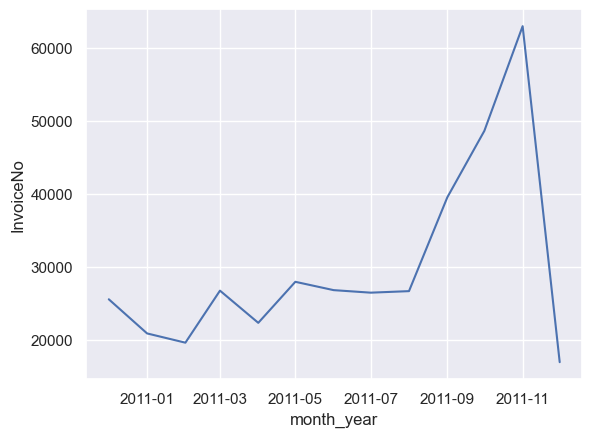

In [124]:
ax = sns.lineplot(x="month_year", y="InvoiceNo", data = plot)

Se realizan más compras a finales de año. El mayor número de transacciones se realizó en noviembre. Probablemente, la razón podría ser que la gente suele prepararse para la Navidad en noviembre. Aparte de noviembre, el número de compras durante el año es bastante similar.

Ahora veamos qué onda las compras por día, que día es el de mayor demanda

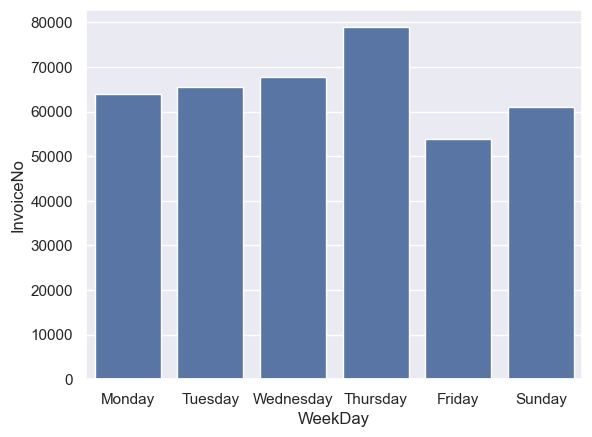

In [125]:
ax = sns.barplot(x="WeekDay", y="InvoiceNo", data = plot2)

Ninguna transacción se realizó el sabado??
 Una posible explicación podría ser algún filtro durante el proceso de recopilación de datos. El número de compras no varía significativamente según el día de la semana.

Veamos que onda las ordenes de compra por hora

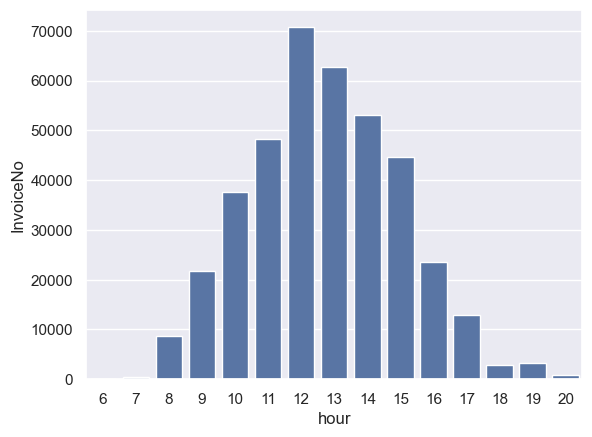

In [126]:
ax = sns.barplot(x="hour", y="InvoiceNo", data = plot3)

Por lo que vemos la mayor cantidad de compras se realizan de 12 a 14. Será que es más conveniente comprar durante esa hora? la menor cantidad de transacciones es entre las 20 y las 7 de la mañana que no se compra practicamente nada.

Veamos el mes en el que se vende más

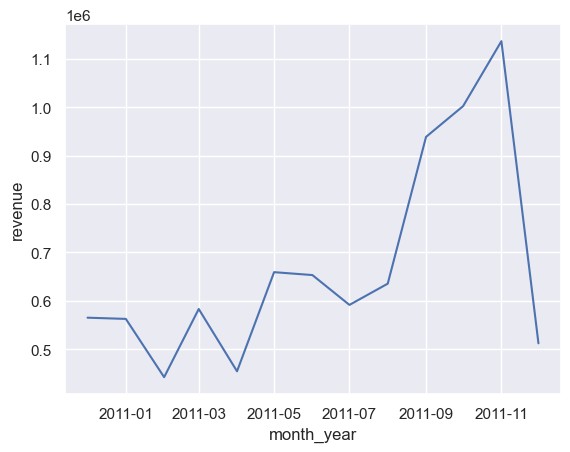

In [127]:
ax = sns.lineplot(x = 'month_year', y='revenue', data = plot5)

Las mayores ventas también se dan durante el mes de noviembre, ya que el número de compras es el más alto.

Ahora veamos qué tal se comporta el precio

In [128]:
pd.DataFrame(data['UnitPrice'].describe())

,UnitPrice
count,391150.000000
mean,2.874372
std,4.284738
min,0.040000
25%,1.250000
50%,1.950000
75%,3.750000
max,649.500000


A partir de las estadísticas descriptivas de la variable precio, observamos que la mayoría de los productos vendidos son bastante económicos. Probablemente, el comercio minorista vende artículos pequeños, como material de oficina, pequeñas decoraciones, etc.

Descripción de productos que cuestan más de 50 (Supuesto: misma moneda para ventas minoristas en diferentes países).

In [129]:
data[data['UnitPrice']>50]['Description'].unique().tolist()

['rustic  seventeen drawer sideboard',
 'vintage post office cabinet',
 'vintage red kitchen cabinet',
 'regency mirror with shutters',
 'love seat antique white metal',
 'vintage blue kitchen cabinet',
 'school desk and chair ',
 'chest natural wood 20 drawers',
 'decorative hanging shelving unit',
 'picnic basket wicker 60 pieces']

Distribución de precios de bienes caros:

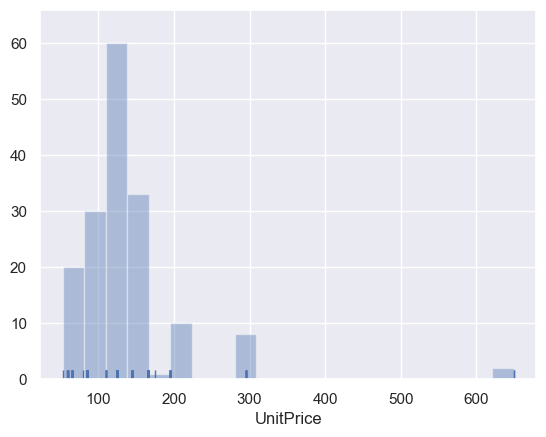

In [130]:
sns.distplot(data[data['UnitPrice']>50]['UnitPrice'], kde=False, rug=True);

Ahora veamos qué tal las transacciones por pais

In [131]:
customer_country=data[['Country','CustomerID']].drop_duplicates()
customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
35,United Kingdom,3916
14,Germany,94
13,France,87
30,Spain,30
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,14
12,Finland,12
1,Austria,11


Como la mayoría son de reino unido, me conviene centrar mi estudio en dicho pais.

Veamos cuantos paises son en total

In [132]:
print("Las transacciones fueron hechas en", len(data['Country'].unique().tolist()), "paises diferentes")

Las transacciones fueron hechas en 37 paises diferentes


In [133]:
print("El numero de transacciones donde el pais es indefinido es:", len(data[data['Country']=='Unspecified']))

El numero de transacciones donde el pais es indefinido es: 241


In [134]:
plot6 = pd.DataFrame(data.groupby(['Country'])['revenue'].sum()).reset_index()
plot6 = plot6.sort_values(['revenue']).reset_index(drop=True)
plot7 = pd.DataFrame(data.groupby(['Country'])['revenue'].count()).reset_index()
plot7 = plot7.sort_values(['revenue']).reset_index(drop=True)

## Cantidades de ventas, ganó UK por mucho

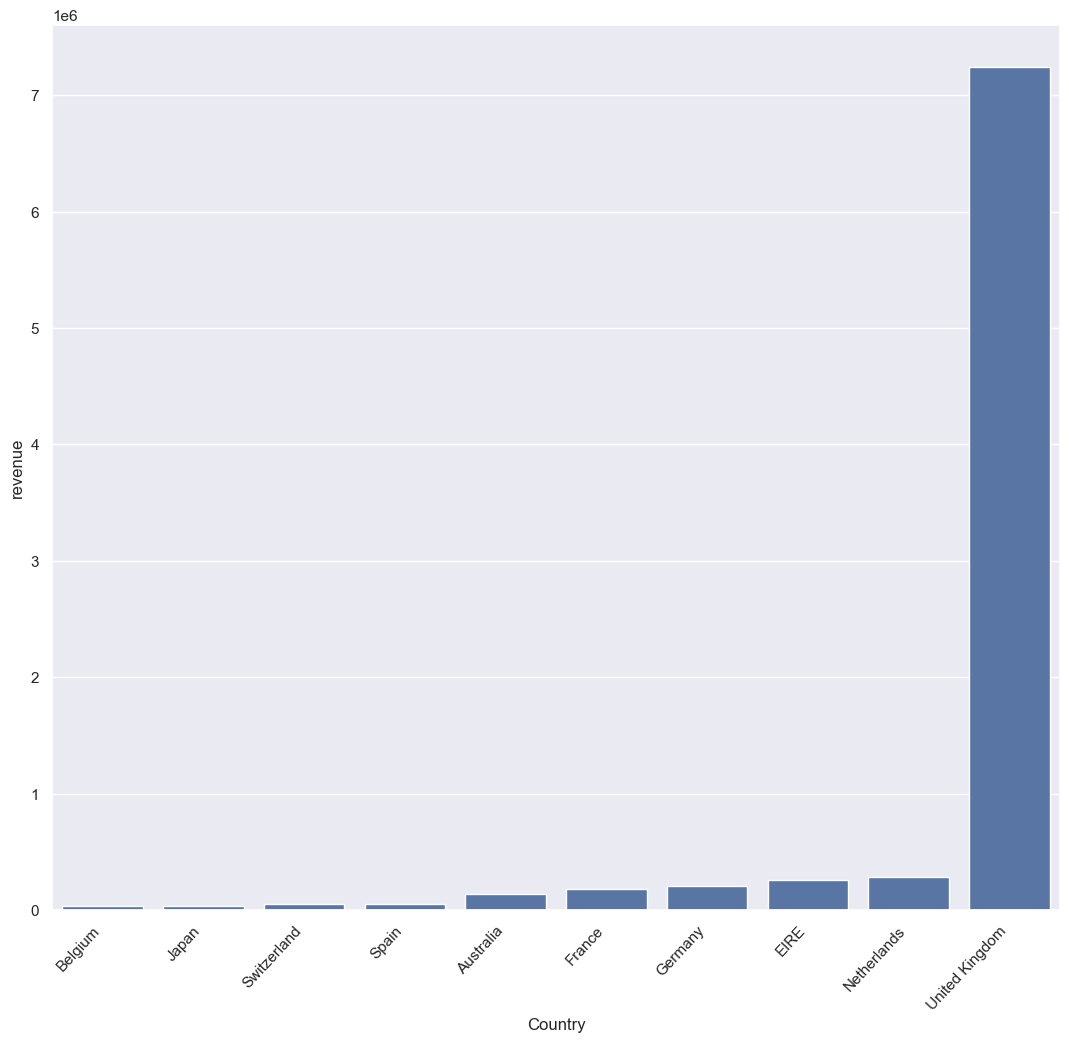

In [135]:
%matplotlib inline
fig, ax = plt.subplots()
fig.set_size_inches(13, 11.5)
ax=sns.barplot(x='Country', y='revenue',data=plot6.tail(10),estimator=max,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=47, ha="right")
plt.show()

## Cantidad de compras, la otra cara de la moneda

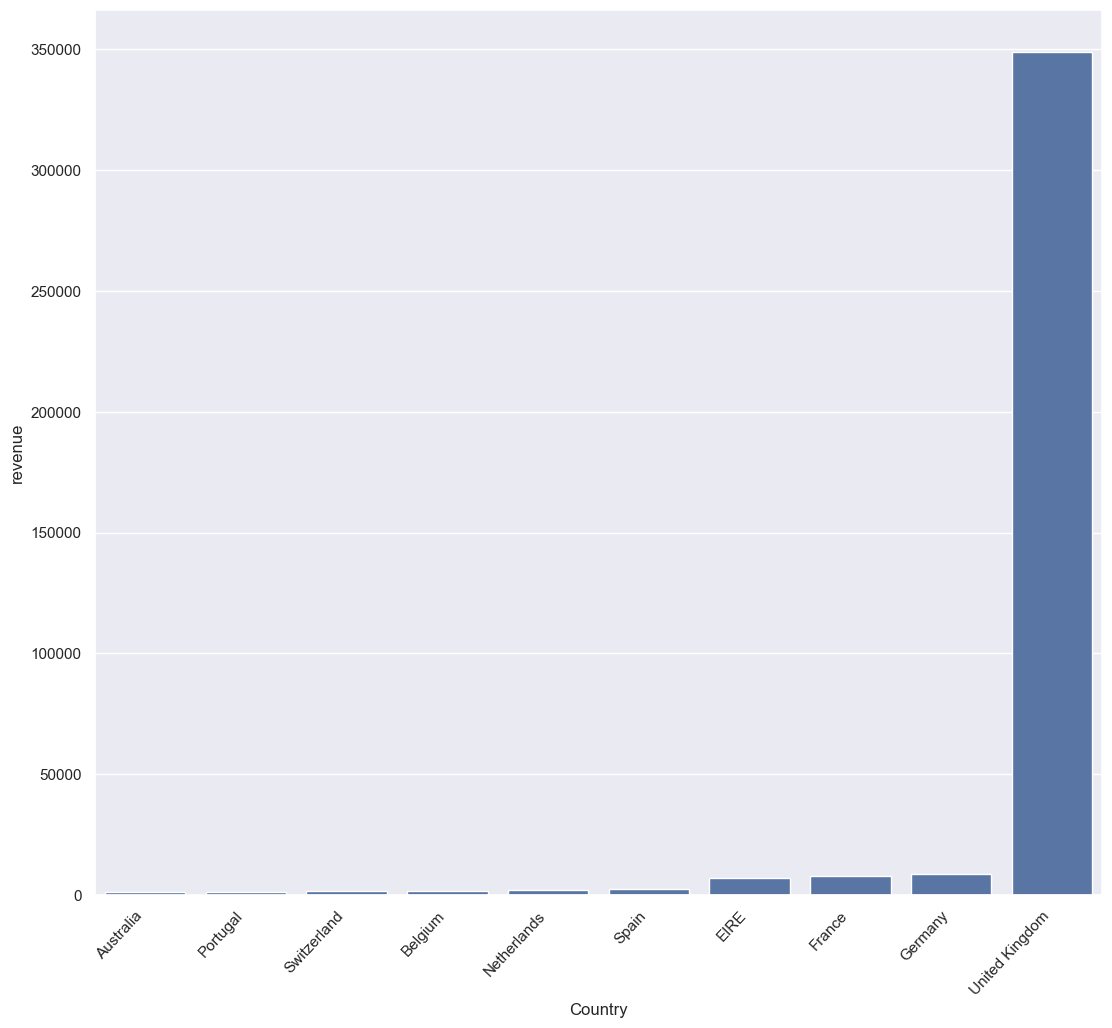

In [136]:
%matplotlib inline
fig, ax = plt.subplots()
fig.set_size_inches(13, 11.5)
ax=sns.barplot(x='Country', y='revenue',data=plot7.tail(10),estimator=max,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=47, ha="right")
plt.show()

vamos a considerar finalmente a uk para nuestro analisis RFM

In [137]:
df_uk = data[data['Country'] == "United Kingdom"]
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month,year,WeekDay,month_year,hour,revenue
0,536365,85123A,white hanging heart tlight holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8,15.30
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8,20.34
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8,22.00
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8,20.34
4,536365,84029E,red woolly hottie white heart,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8,20.34
